<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/image/IDSN-logo.png" width="200" alt="cognitiveclass.ai logo">


# Project: Concrete Cracks Detection in Buildings

Student's name: H.N.Huy NGUYEN

This project is the final project in the specialization of AI Engineering which I'm currently learning. 

The objective of the project is to use pre-trained model 'Resnet18' for the use of cracks detection in buildings

Throughout the project I've got to learn about how to: 
<ul>
<li>build and modify the ouput of a pre-trained model of Deep Learning</li>
<li>evaluate the accuracy and loss of the model</li>
<li>apply what I've learnt to train and to use the model for classification process</li>
</ul>

<h2>Table of Contents</h2>


<div class="alert alert-block alert-info" style="margin-top: 20px">


<ul>
    <li><a href="#data"> Download Data</a></li>
    <li><a href="#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="#data-class">Data Preparation</a></li>
    <li><a href="#pretrained_model">Setting up pre-trained model</a></li>
    <li><a href="#training">Training model</a></li>
    <li><a href="#results">Results</a></li>
    <li><a href="#misclassified">Finding misclassified samples</a></li>
</ul>
 </div>
<hr>


<h2 id="data">Dataset and Torch-Vision models</h2>


Link to download the dataset:
<ul>
<li>Positive dataset: https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip </li>
<li>Negative dataset: https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip</li>
</ul>

### Dataset information:
<ul>
<li>40000 RGB images</li>
<li>20000 images with cracks (or positive label)</li>
<li>20000 images with no cracks (or negative label)</li>
<li>75% of the imgages will be used for training</li>
</ul>

### Datset Challenges:
<ul>
<li>Crack can be confused with noise in the background texture or foreign objects</li>
<li>Inhomogeneous illumination</li>
<li>Irregularities such as exposure of jointing</li>
</ul>

We will install torchvision:


In [1]:
#!pip install torchvision

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


The following are the libraries we are going to use for this project. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.


In [2]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [3]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->


<h2 id="data_class">Data Preparation - Dataset Class</h2>


 This dataset class is essentially the same dataset you build in the previous section, but to speed things up, we are going to use tensors instead of jpeg images. Therefore for each iteration, we don't have to do reshape step, conversion step to tensors and normalization step.


In [4]:
# Create dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="D:/ML/Course/IBM_ProjectCapstone"
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is going to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


We create two dataset objects, one for the training data and one for the validation data.


In [5]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


<h2 id="Pretrained_model">Setting up pre-trained model</h2>


<b>Prepare a pre-trained resnet18 model :</b>


<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:


In [6]:
model = models.resnet18(pretrained = True)

#Normalize the image channels:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

composed = transforms.Compose([transforms.Resize(224), transforms.ToTensor(), transforms.Normalize(mean,std)])

C:\Users\nhath\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nhath\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [7]:
for param in model.parameters():
    param.required_grad = False

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs. 


<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.


In [8]:
model.fc = nn.Linear(512, 2)

Model preview:

In [9]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2 id="training">Model Training</h2>


In this section we will train our model to classify images.


<b>Step 1</b>: Create a cross entropy criterion function 


In [10]:
# Create the loss function
criterion = nn.CrossEntropyLoss()

training_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size=100)

In [11]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

<!--Empty Space for separating topics-->


### Train the model

In [12]:

n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
#n_epochs

Loss=0
start_time = time.time()
for epoch in range(n_epochs):
    loss_sublist = []
    for i, (x, y) in enumerate(training_loader):

        model.train() 
        #clear gradient 
        optimizer.zero_grad()
        #make a prediction 
        z = model(x)
        # calculate loss 
        loss = criterion(z, y)
        # calculate gradients of parameters 
        loss_sublist.append(loss.data.item())
        loss.backward()
        # update parameters 
        
        optimizer.step()
        loss_list.append(np.mean(loss_sublist))
        
        # Print training progress
        print(f"Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{len(training_loader)}], Loss: {loss.data.item()}")

print("done")
    

Epoch [1/1], Step [1/300], Loss: 0.6997301578521729
Epoch [1/1], Step [2/300], Loss: 0.11786480247974396
Epoch [1/1], Step [3/300], Loss: 0.09667705744504929
Epoch [1/1], Step [4/300], Loss: 0.008437400683760643
Epoch [1/1], Step [5/300], Loss: 0.005320911295711994
Epoch [1/1], Step [6/300], Loss: 0.009892147965729237
Epoch [1/1], Step [7/300], Loss: 0.01579538732767105
Epoch [1/1], Step [8/300], Loss: 0.0016814136179164052
Epoch [1/1], Step [9/300], Loss: 0.08664587885141373
Epoch [1/1], Step [10/300], Loss: 0.08722168207168579
Epoch [1/1], Step [11/300], Loss: 0.02682327665388584
Epoch [1/1], Step [12/300], Loss: 0.0037730729673057795
Epoch [1/1], Step [13/300], Loss: 0.04279293119907379
Epoch [1/1], Step [14/300], Loss: 0.02317347750067711
Epoch [1/1], Step [15/300], Loss: 0.046296391636133194
Epoch [1/1], Step [16/300], Loss: 0.0419735424220562
Epoch [1/1], Step [17/300], Loss: 0.13941402733325958
Epoch [1/1], Step [18/300], Loss: 0.029094042256474495
Epoch [1/1], Step [19/300], Lo

### Evaluate the model using the validation loader

In [13]:
    correct=0
    misclassified_samples = []
    
    for i, (x_test, y_test) in enumerate(validation_loader):
        # set model to eval 
        model.eval()
        #make a prediction 
        z = model(x_test)
        #find max 
        _, yhat = torch.max(z.data, 1)
       
        #Calculate misclassified  samples in mini-batch 
        #hint +=(yhat==y_test).sum().item()
        correct += (yhat == y_test).sum().item()
        
        # Stock the misclassified samples
        for idx in range(len(y_test)):
            if (yhat[idx] != y_test[idx]):
                    misclassified_samples.append((x_test[idx], yhat[idx], y_test[idx]))
        
        # Print validation progress
        print(f"Epoch [{epoch+1}/{n_epochs}], Validation: Step [{i+1}/{len(validation_loader)}]")
   
        

    accuracy=correct/N_test
    accuracy_list.append(accuracy)
    # Print epoch number, loss, and accuracy
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss_list[-1]}, Accuracy: {accuracy}")

    # Calculate and print out training time
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time} seconds")

Epoch [1/1], Validation: Step [1/100]
Epoch [1/1], Validation: Step [2/100]
Epoch [1/1], Validation: Step [3/100]
Epoch [1/1], Validation: Step [4/100]
Epoch [1/1], Validation: Step [5/100]
Epoch [1/1], Validation: Step [6/100]
Epoch [1/1], Validation: Step [7/100]
Epoch [1/1], Validation: Step [8/100]
Epoch [1/1], Validation: Step [9/100]
Epoch [1/1], Validation: Step [10/100]
Epoch [1/1], Validation: Step [11/100]
Epoch [1/1], Validation: Step [12/100]
Epoch [1/1], Validation: Step [13/100]
Epoch [1/1], Validation: Step [14/100]
Epoch [1/1], Validation: Step [15/100]
Epoch [1/1], Validation: Step [16/100]
Epoch [1/1], Validation: Step [17/100]
Epoch [1/1], Validation: Step [18/100]
Epoch [1/1], Validation: Step [19/100]
Epoch [1/1], Validation: Step [20/100]
Epoch [1/1], Validation: Step [21/100]
Epoch [1/1], Validation: Step [22/100]
Epoch [1/1], Validation: Step [23/100]
Epoch [1/1], Validation: Step [24/100]
Epoch [1/1], Validation: Step [25/100]
Epoch [1/1], Validation: Step [26/

<h2 id="results">Results</h2>

In [14]:
print(accuracy)

0.9986


### Print the loss list after iterations
Remark:

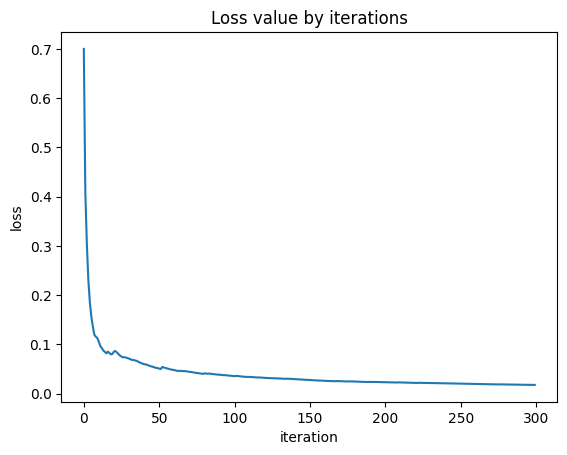

In [15]:
plt.plot(loss_list)
plt.title("Loss value by iterations")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


<h2 id="misclassified">Find the misclassified samples</h2> 


Identify the first four misclassified samples using the validation data:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


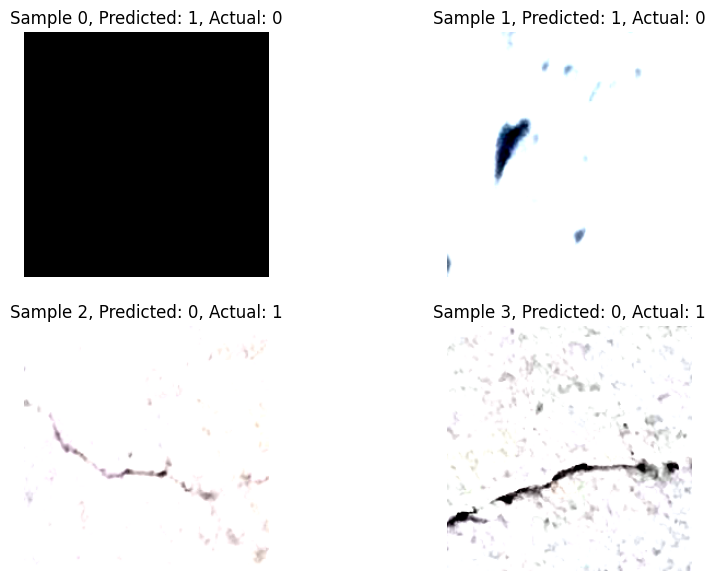

In [22]:
fig = plt.figure(figsize=(10,7))
for i in range(4):
    x_test, yhat, y_test = misclassified_samples[i]
    image = x_test.permute(1,2,0).numpy()
    fig.add_subplot(2,2,i+1)
    plt.imshow(image)
    plt.title(f'Sample {i}, Predicted: {yhat}, Actual: {y_test}')
    plt.axis('off')

    

In [ ]:
f, 

### Remark:
Some images are misclassified because of:
<ul>
<li>Lack of quality of the image</li>
<li>Intensity and contrast</li>
<li>Noise and variability</li>
<li>...</li>
</ul>

Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>.
